# LENET模型

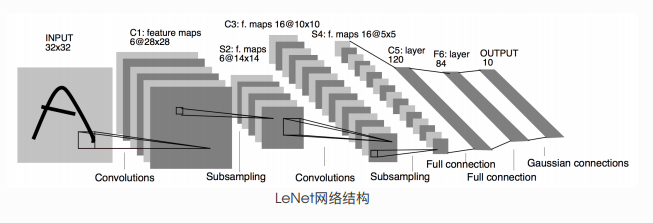

LeNet分为卷积层块和全连接层块两个部分。下⾯我们分别介绍这两个模块。
<p>卷积层块⾥的基本单位是卷积层后接最⼤池化层：卷积层⽤来识别图像⾥的空间模式，如线条和物体局
部，之后的最⼤池化层则⽤来降低卷积层对位置的敏感性。卷积层块由两个这样的基本单位重复堆叠构
成。在卷积层块中，每个卷积层都使⽤5x5的窗⼝，并在输出上使⽤sigmoid激活函数。第⼀个卷积层
输出通道数为6，第⼆个卷积层输出通道数则增加到16。这是因为第⼆个卷积层⽐第⼀个卷积层的输⼊
的⾼和宽要⼩，所以增加输出通道使两个卷积层的参数尺⼨类似。卷积层块的两个最⼤池化层的窗⼝形
状均为 2x2,且步幅为2。由于池化窗⼝与步幅形状相同，池化窗⼝在输⼊上每次滑动所覆盖的区域互
不重叠。</p>
<p>卷积层块的输出形状为(批量⼤⼩, 通道, ⾼, 宽)。当卷积层块的输出传⼊全连接层块时，全连接层块会
将⼩批量中每个样本变平（flatten）。也就是说，全连接层的输⼊形状将变成⼆维，其中第⼀维是⼩批
量中的样本，第⼆维是每个样本变平后的向量表示，且向量⻓度为通道、⾼和宽的乘积。全连接层块含
3个全连接层。它们的输出个数分别是120、84和10，其中10为输出的类别个数</p>

In [1]:
import time
import torch
from torch import nn,optim
import sys
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(6,16,5),
            nn.Sigmoid(),
            nn.MaxPool2d(2,2)
        )
        self.fc=nn.Sequential(
            nn.Linear(16*4*4,120),
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,10)
        )
    def forward(self,img):
        feature=self.conv(img)
        output=self.fc(feature.view(img.shape[0],-1))
        return output

In [2]:
net=LeNet()
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# 获取数据和训练数据

In [6]:
import torchvision
import torchvision.transforms as transforms
batch_size=256
mnist_train=torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST',train=True,download=False,transform=transforms.ToTensor())
mnist_test=torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST',train=False,download=False,transform=transforms.ToTensor())
if sys.platform.startswith('win'):
    num_workers=0
else:
    num_workers=4
train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=num_workers)

In [17]:
def evaluate_accuracy(data_iter,net,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()#评估模式，这会关闭dropout
                acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
                net.train()#改回训练模式
            else:
                if('is_training' in net.__code__.co_varname):
                    acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

In [11]:
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on ',device)
    loss=torch.nn.CrossEntropyLoss()
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f,time %.lf sec'%(epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))
        

In [18]:
lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net=net,train_iter=train_iter,test_iter=test_iter,batch_size=batch_size,optimizer=optimizer,device='cuda',num_epochs=num_epochs)

training on  cuda
epoch 1,loss 0.4429,train acc 0.830,test acc 0.823,time 10 sec
epoch 2,loss 0.2147,train acc 0.839,test acc 0.831,time 10 sec
epoch 3,loss 0.1398,train acc 0.843,test acc 0.829,time 10 sec
epoch 4,loss 0.1023,train acc 0.846,test acc 0.838,time 10 sec
epoch 5,loss 0.0799,train acc 0.851,test acc 0.842,time 10 sec


In [19]:
torch.save(net.state_dict(),'LeNet_state_dict.pt')